# Démo : Projet Big Data Spark


**les réalisateurs du projet**: NAIT EL KADI Oumaima & BENABBOU Nada

**Encadré par**: Pr. BENHLIMA Lamia

Dans ce demo, nous effectuerons l'analyse exploratoire des données médicales à l'aide de la dataframe PySpark en python dans lequel nous effectuerons le prétraitement et la prédiction .

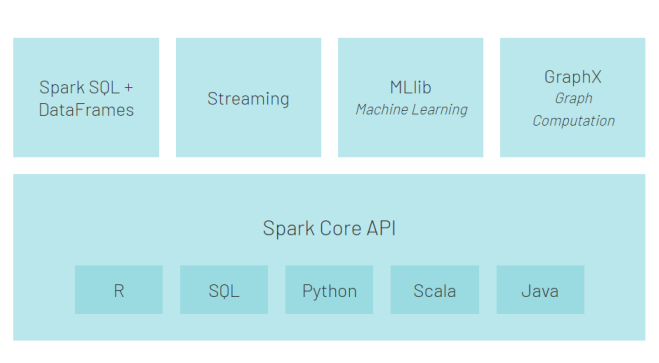

**La bibliothèque Python PySpark**

PySpark est une librairie qui permet d'utiliser Apache Spark avec le langage de programmation Python




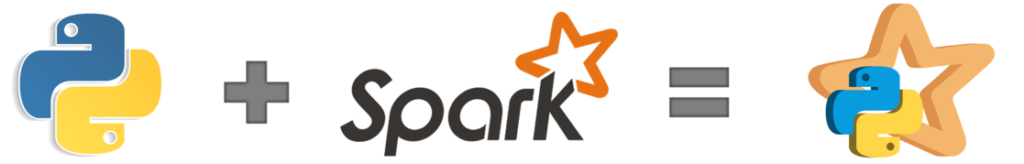

**PySpark Data Source: Chronic Kidney Disease Dataset**

**Sujet choisi**

la maladie que nous avons choisi sur Kaggle est La maladie rénale chronique est une diminution du fonctionnement des reins qui ne filtrent plus correctement le sang de l'organisme.

**Objective**

L'objectif est de prédire si oui ou non un patient est atteint du maladie rénale
chronique à partir de certains attributs : par exemple, le nombre de globules rouges, le
nombre de globules blancs, etc.

**Pipeline**

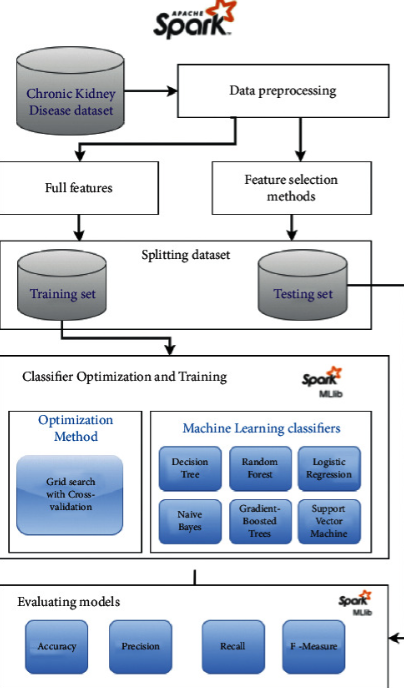

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 22 kB/s 
     |████████████████████████████████| 199 kB 12.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=42c4871263762a71f09e7f7253c1ff51c280c78d8cd9c685eefc3e6603f26417
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
import pyspark
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

In [ ]:
spark = SparkSession.builder.master('local').appName('projectBigData').getOrCreate()
spark

Montrons notre dataframe PySpark Tout comme Pandas head, nous pouvons utiliser les fonctions show et head pour afficher les N premières lignes de la dataframe.

In [ ]:
spark_df = spark.read.csv("/content/kidney_disease.csv",header = True, inferSchema = True)
spark_df.show(5,False)

+---+----+----+-----+---+---+------+--------+----------+----------+-----+----+---+-----+----+----+---+----+----+---+---+---+-----+---+---+--------------+
|id |age |bp  |sg   |al |su |rbc   |pc      |pcc       |ba        |bgr  |bu  |sc |sod  |pot |hemo|pcv|wc  |rc  |htn|dm |cad|appet|pe |ane|classification|
+---+----+----+-----+---+---+------+--------+----------+----------+-----+----+---+-----+----+----+---+----+----+---+---+---+-----+---+---+--------------+
|0  |48.0|80.0|1.02 |1.0|0.0|null  |normal  |notpresent|notpresent|121.0|36.0|1.2|null |null|15.4|44 |7800|5.2 |yes|yes|no |good |no |no |ckd           |
|1  |7.0 |50.0|1.02 |4.0|0.0|null  |normal  |notpresent|notpresent|null |18.0|0.8|null |null|11.3|38 |6000|null|no |no |no |good |no |no |ckd           |
|2  |62.0|80.0|1.01 |2.0|3.0|normal|normal  |notpresent|notpresent|423.0|53.0|1.8|null |null|9.6 |31 |7500|null|no |yes|no |poor |no |yes|ckd           |
|3  |48.0|70.0|1.005|4.0|0.0|normal|abnormal|present   |notpresent|117.0|56.

In [ ]:
spark_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- bp: double (nullable = true)
 |-- sg: double (nullable = true)
 |-- al: double (nullable = true)
 |-- su: double (nullable = true)
 |-- rbc: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- pcc: string (nullable = true)
 |-- ba: string (nullable = true)
 |-- bgr: double (nullable = true)
 |-- bu: double (nullable = true)
 |-- sc: double (nullable = true)
 |-- sod: double (nullable = true)
 |-- pot: double (nullable = true)
 |-- hemo: double (nullable = true)
 |-- pcv: string (nullable = true)
 |-- wc: string (nullable = true)
 |-- rc: string (nullable = true)
 |-- htn: string (nullable = true)
 |-- dm: string (nullable = true)
 |-- cad: string (nullable = true)
 |-- appet: string (nullable = true)
 |-- pe: string (nullable = true)
 |-- ane: string (nullable = true)
 |-- classification: string (nullable = true)



In [ ]:
data = spark_df.toPandas()
data

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,None,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,None,normal,notpresent,notpresent,...,38,6000,None,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,None,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,51,7200,5.9,no,no,no,good,no,no,notckd


In [ ]:
data.columns

Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification'],
      dtype='object')

In [ ]:
# converting necessary columns to numerical type

data['pcv'] = pd.to_numeric(data['pcv'], errors='coerce')
data['wc'] = pd.to_numeric(data['wc'], errors='coerce')
data['rc'] = pd.to_numeric(data['rc'], errors='coerce')

**EDA**

In [ ]:
print("The shape of the dataset is : ", data.shape)

The shape of the dataset is :  (400, 26)


In [ ]:
dict = {}
for i in list(data.columns):
    dict[i] = data[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
id,400
age,76
bp,10
sg,5
al,6
su,6
rbc,2
pc,2
pcc,2
ba,2


In [ ]:
cat_col=[col for col in data.columns if data[col].dtype=="object"]
num_col=[col for col in data.columns if data[col].dtype!="object"]
print("The continuous  cols are : ", num_col)
print("The categorial col is our target variable:  ", cat_col)

The continuous  cols are :  ['id', 'age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
The categorial col is our target variable:   ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']


In [ ]:
data.classification.unique()

array(['ckd', 'ckd\t', 'notckd'], dtype=object)

In [ ]:
data.classification=data.classification.replace("ckd\t","ckd")
data.classification.unique()

array(['ckd', 'notckd'], dtype=object)

In [ ]:
data['classification']=data['classification'].replace(['ckd',"notckd"],[1,0])

In [ ]:
data.dm=data["dm"]. replace( ["\tno",'\tyes'],["no","yes"])
data.cad= data['cad'].replace('\tno','no')
data.dm=data.dm.replace(" yes","yes")
data.pcc.unique()
data['pcc']=data['pcc'].replace(['notpresent',"present"],[1,0])
data['rbc']=data['rbc'].replace(['normal',"abnormal"],[1,0])
data['ba']=data['ba'].replace(['notpresent',"present"],[1,0])
data['htn']=data['htn'].replace(['yes',"no"],[1,0])
data['dm']=data['dm'].replace(['yes',"no"],[1,0])
data['cad']=data['cad'].replace(['no',"yes"],[1,0])
data['appet']=data['appet'].replace(['good',"poor"],[1,0])
data['pc']=data['pc'].replace(['normal',"abnormal"],[1,0])
data['pe']=data['pe'].replace(['no',"yes"],[1,0])
data['ane']=data['ane'].replace(['no',"yes"],[1,0])

**Treating missing values:**

In [ ]:
data.isnull().sum()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                71
wc                106
rc                131
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

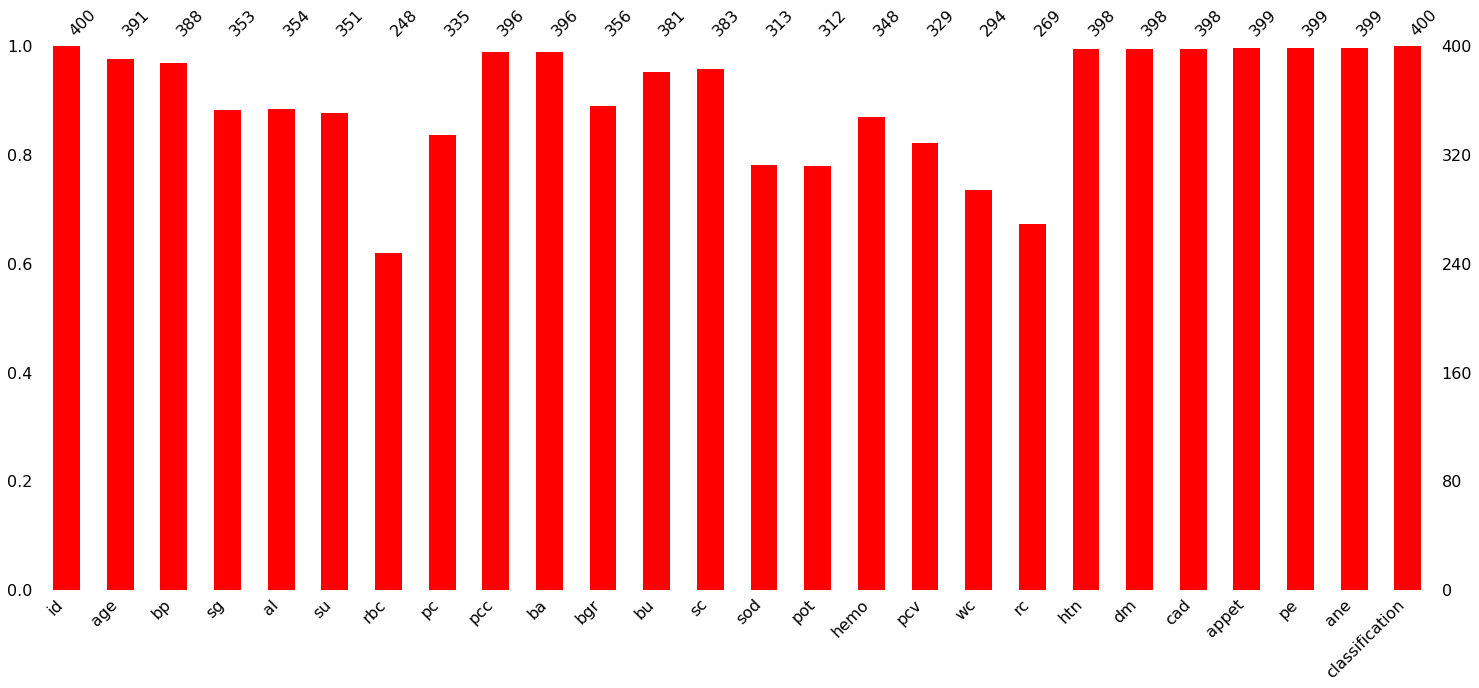

In [ ]:
import missingno as msn
msn.bar(data,color="red");

In [ ]:
# Let's impute Nan Values with median in numeric features
for col in num_col:
    data[col]=data[col].fillna(data[col].median())

In [ ]:
for col in cat_col:
    print(f" {col} most frequent value is {data[col].mode()}\n")

 rbc most frequent value is 0    1.0
dtype: float64

 pc most frequent value is 0    1.0
dtype: float64

 pcc most frequent value is 0    1.0
dtype: float64

 ba most frequent value is 0    1.0
dtype: float64

 htn most frequent value is 0    0.0
dtype: float64

 dm most frequent value is 0    0.0
dtype: float64

 cad most frequent value is 0    1.0
dtype: float64

 appet most frequent value is 0    1.0
dtype: float64

 pe most frequent value is 0    1.0
dtype: float64

 ane most frequent value is 0    1.0
dtype: float64

 classification most frequent value is 0    1
dtype: int64



In [ ]:
data.isnull()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
396,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
397,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
398,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
data['rbc'].fillna(1,inplace=True)
data['ane'].fillna(1,inplace=True)
data['pe'].fillna(1,inplace=True)
data["cad"].fillna(1,inplace=True)
data['dm'].fillna(0,inplace=True)
data['pcc'].fillna(1,inplace=True)
data["htn"].fillna(0,inplace=True) 
data["appet"].fillna(1,inplace=True)
data["pc"].fillna(1,inplace=True)
data["ba"].fillna(1,inplace=True)

In [ ]:
rdd = spark.sparkContext.parallelize(data)
df = spark.createDataFrame(data)

In [ ]:
df.show(10,False)

+---+----+-----+-----+---+---+---+---+---+---+-----+-----+----+-----+---+----+----+-------+---+---+---+---+-----+---+---+--------------+
|id |age |bp   |sg   |al |su |rbc|pc |pcc|ba |bgr  |bu   |sc  |sod  |pot|hemo|pcv |wc     |rc |htn|dm |cad|appet|pe |ane|classification|
+---+----+-----+-----+---+---+---+---+---+---+-----+-----+----+-----+---+----+----+-------+---+---+---+---+-----+---+---+--------------+
|0  |48.0|80.0 |1.02 |1.0|0.0|1.0|1.0|1.0|1.0|121.0|36.0 |1.2 |138.0|4.4|15.4|44.0|7800.0 |5.2|1.0|1.0|1.0|1.0  |1.0|1.0|1             |
|1  |7.0 |50.0 |1.02 |4.0|0.0|1.0|1.0|1.0|1.0|121.0|18.0 |0.8 |138.0|4.4|11.3|38.0|6000.0 |4.8|0.0|0.0|1.0|1.0  |1.0|1.0|1             |
|2  |62.0|80.0 |1.01 |2.0|3.0|1.0|1.0|1.0|1.0|423.0|53.0 |1.8 |138.0|4.4|9.6 |31.0|7500.0 |4.8|0.0|1.0|1.0|0.0  |1.0|0.0|1             |
|3  |48.0|70.0 |1.005|4.0|0.0|1.0|0.0|0.0|1.0|117.0|56.0 |3.8 |111.0|2.5|11.2|32.0|6700.0 |3.9|1.0|0.0|1.0|0.0  |0.0|0.0|1             |
|4  |51.0|80.0 |1.01 |2.0|0.0|1.0|1.0|1.0

In [ ]:
df.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
id,400,199.5,115.61430130683084,0,399
age,400,51.5625,16.982995881846257,2.0,90.0
bp,400,76.575,13.489785423680479,50.0,180.0
sg,400,1.0177124999999916,0.005434028470070733,1.005,1.025
al,400,0.9,1.3131301447085713,0.0,5.0
su,400,0.395,1.040038075262145,0.0,5.0
rbc,400,0.8825,0.3224184146186646,0.0,1.0
pc,400,0.81,0.3927922024247863,0.0,1.0
pcc,400,0.895,0.3069373328804914,0.0,1.0


In [ ]:
df.groupby('classification').count().show()

+--------------+-----+
|classification|count|
+--------------+-----+
|             0|  150|
|             1|  250|
+--------------+-----+



In [ ]:
data.describe(include="all")

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
count,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,...,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,199.500000,51.562500,76.575000,1.017712,0.90000,0.395000,0.882500,0.810000,0.895000,0.945000,...,39.082500,8298.500000,4.737750,0.367500,0.34250,0.915000,0.795000,0.810000,0.850000,0.625000
std,115.614301,16.982996,13.489785,0.005434,1.31313,1.040038,0.322418,0.392792,0.306937,0.228266,...,8.162245,2529.593814,0.841439,0.482728,0.47514,0.279231,0.404207,0.392792,0.357519,0.484729
min,0.000000,2.000000,50.000000,1.005000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,2200.000000,2.100000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99.750000,42.000000,70.000000,1.015000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,...,34.000000,6975.000000,4.500000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,199.500000,55.000000,80.000000,1.020000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,...,40.000000,8000.000000,4.800000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,299.250000,64.000000,80.000000,1.020000,2.00000,0.000000,1.000000,1.000000,1.000000,1.000000,...,44.000000,9400.000000,5.100000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
max,399.000000,90.000000,180.000000,1.025000,5.00000,5.000000,1.000000,1.000000,1.000000,1.000000,...,54.000000,26400.000000,8.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

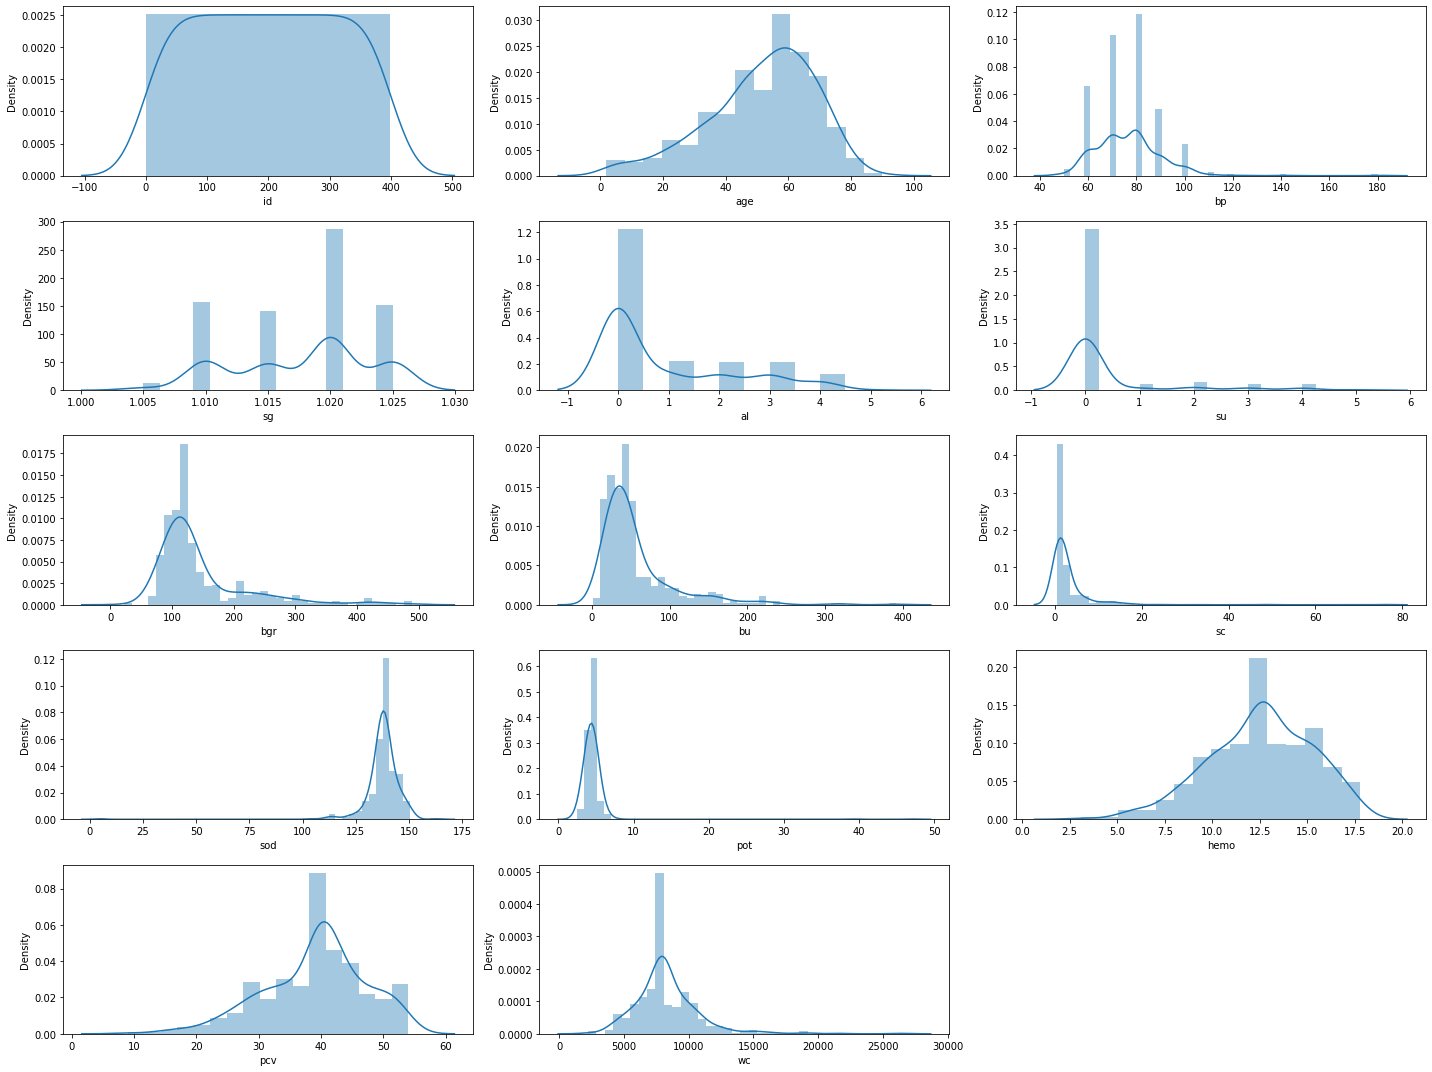

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,15))
plotnumber=1
for column in num_col:
    if plotnumber<=14:
        ax = plt.subplot(5,3,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column)
        
    plotnumber += 1 
plt.tight_layout()
plt.show()  

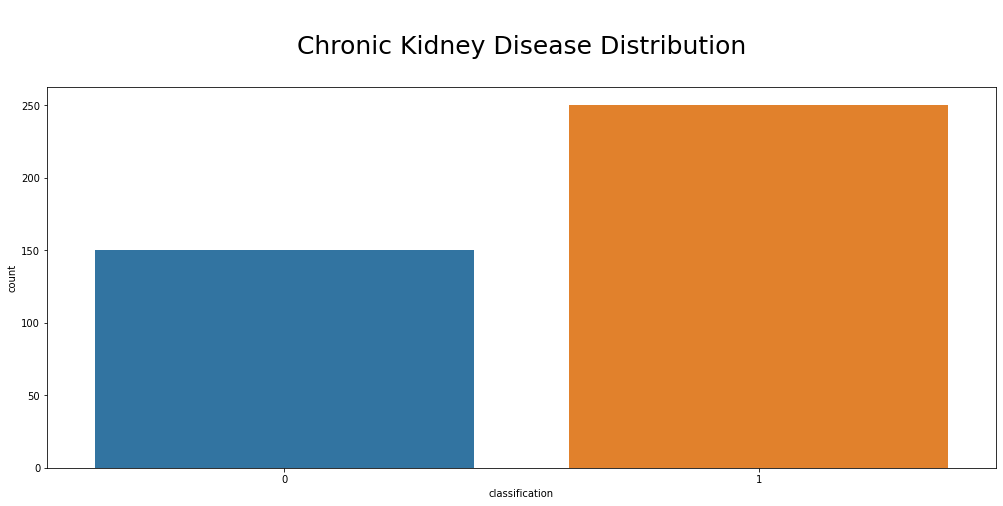

In [ ]:
plt.figure(figsize=(17,7))
sns.countplot(data=data, x="classification")
plt.title("\nChronic Kidney Disease Distribution\n", fontsize=25)
plt.show();

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

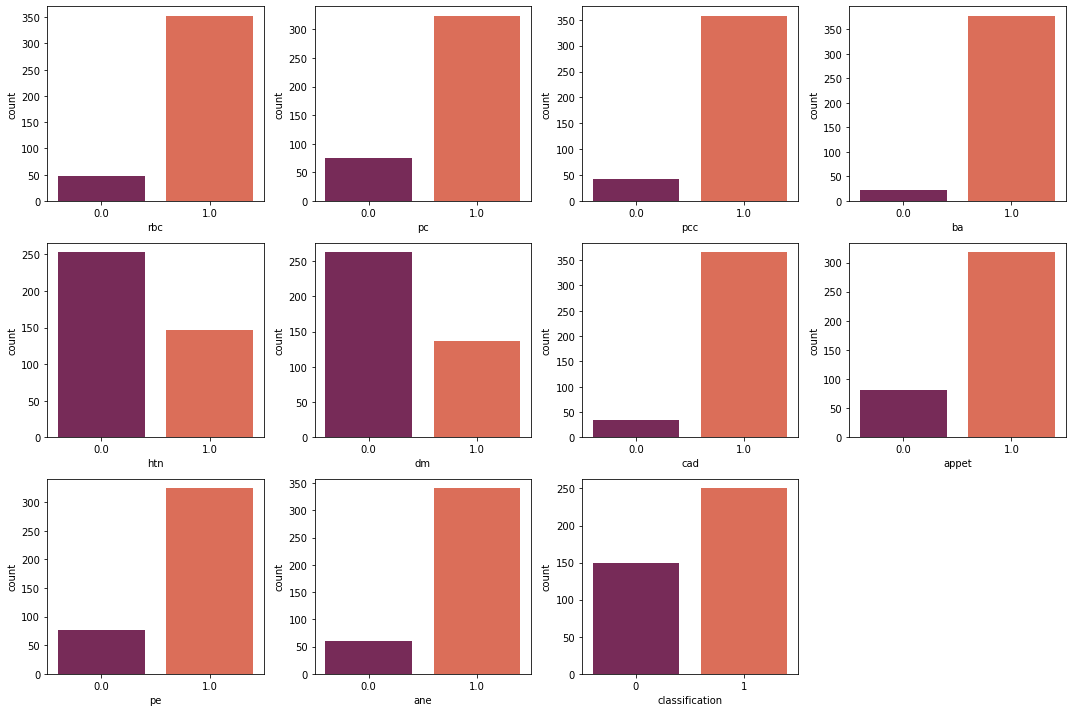

In [ ]:
# looking at categorical columns

plt.figure(figsize = (15, 10))
plotnumber = 1

for column in cat_col:
    if plotnumber <= 11:
        ax = plt.subplot(3, 4, plotnumber)
        sns.countplot(data[column], palette = 'rocket')
        plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

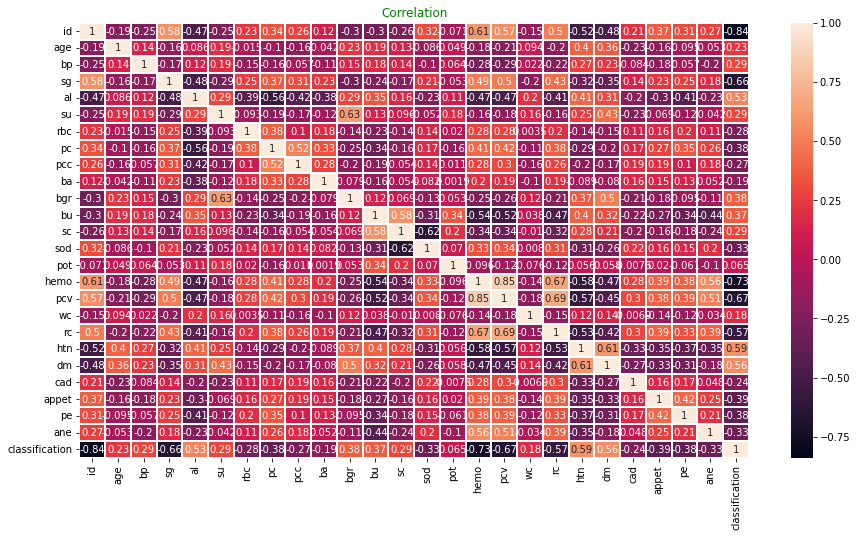

In [ ]:
plt.figure(figsize=(15,8));
plt.title("Correlation",color="green")
sns.heatmap(data.corr(),linewidth=1,annot=True)

La plage normale de l'urée sanguine se situe entre 15 et 40. Lorsque l'urée sanguine dépasse 40, les risques d'augmentation de l'insuffisance rénale peuvent être observés sur le diagramme de dispersion.
La plage normale de l'urée sanguine se situe entre 15 et 40. Lorsque l'urée sanguine dépasse 40, les risques d'augmentation de l'insuffisance rénale peuvent être observés sur le diagramme de dispersion.

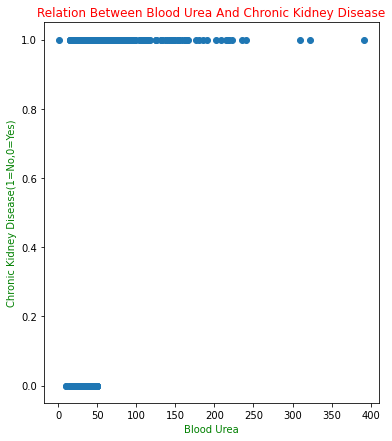

In [ ]:
fig, ax = plt.subplots(figsize=(6,7))
M=data[['bu']]
N=data[['classification']]
plt.title("Relation Between Blood Urea And Chronic Kidney Disease",color="red");
plt.xlabel("Blood Urea",color="green")
plt.ylabel("Chronic Kidney Disease(1=No,0=Yes)",color="green")
ax.scatter(M,N);
plt.show();

La plage normale de la créatine sérique est comprise entre 0,5 et 1,5. Lorsque la créatine sérique dépasse 1,5, les risques d'augmentation de l'insuffisance rénale peuvent être observés sur le diagramme de dispersion.

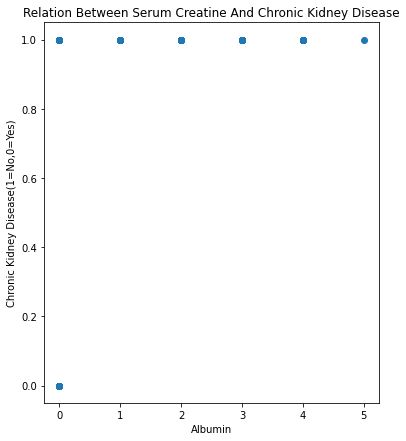

In [ ]:
fig, ax = plt.subplots(figsize=(6,7))
M=data[['al']]
N=data[['classification']]
plt.title("Relation Between Serum Creatine And Chronic Kidney Disease");
plt.xlabel("Albumin")
plt.ylabel("Chronic Kidney Disease(1=No,0=Yes)")
ax.scatter(M,N);
plt.show();

Les diabétiques sont également l'une des principales raisons de l'insuffisance rénale.

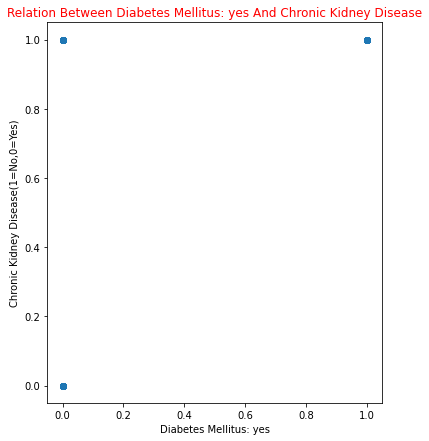

In [ ]:
fig, ax = plt.subplots(figsize=(6,7))
M=data[['dm']]
N=data[['classification']]
plt.title("Relation Between Diabetes Mellitus: yes And Chronic Kidney Disease",color="red");
plt.xlabel("Diabetes Mellitus: yes")
plt.ylabel("Chronic Kidney Disease(1=No,0=Yes)")
ax.scatter(M,N);
plt.show();

# Defining Target or Dependent Variable (y) and Feature or Independent Variables (X)

In [ ]:
X=data[[ 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane']]
y=data[['classification']]

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=222)

In [ ]:
print("Training Data ::-")
print("The shape of X training data is :-" ,X_train.shape)
print("The shape of y training data is :-" ,y_train.shape)

Training Data ::-
The shape of X training data is :- (300, 24)
The shape of y training data is :- (300, 1)


In [ ]:
print("Testing Data ::-")
print("The shape of X testing data is :-" ,X_test.shape)
print("The shape of y testing data is :-" ,y_test.shape)

Testing Data ::-
The shape of X testing data is :- (100, 24)
The shape of y testing data is :- (100, 1)


In [ ]:
X=data[['age', 'bp', 'sg', 'al', 'su',  'pcc', 'ba', 'bgr','bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad','appet', 'pe', 'ane']]

In [ ]:
from sklearn.preprocessing import StandardScaler
sss=StandardScaler()
X=sss.fit_transform(X)
X.shape
X

array([[-0.21003135,  0.25421378,  0.4214856 , ...,  0.50780078,
         0.4843221 ,  0.42008403],
       [-2.62723421, -1.97247624,  0.4214856 , ...,  0.50780078,
         0.4843221 ,  0.42008403],
       [ 0.615355  ,  0.25421378, -1.4210744 , ..., -1.96927621,
         0.4843221 , -2.38047614],
       ...,
       [-2.33245337,  0.25421378,  0.4214856 , ...,  0.50780078,
         0.4843221 ,  0.42008403],
       [-2.03767254, -1.23024623,  1.3427656 , ...,  0.50780078,
         0.4843221 ,  0.42008403],
       [ 0.37953033,  0.25421378,  1.3427656 , ...,  0.50780078,
         0.4843221 ,  0.42008403]])

As we prepared our input features PySpark dataframe, now it is the right time to define our training and testing dataset to train our model on sufficient training dataset and then use unseen or test dataset to evaluate the performance of our Logistic Regression model later.

**Distribution of Dataset**

In [ ]:
#Split the dataset into training and testing dataset

splits = rdd.randomSplit([0.8, 0.2])
df_train = splits[0]
df_test = splits[1]

**Spiliting into train and test set:**

In [ ]:
#Split the dataset into training and testing dataset
splits = rdd.randomSplit([0.8, 0.2])
df_train = splits[0]
df_test = splits[1]


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features_norm", numTrees=10)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluter=MulticlassClassificationEvaluator(labelCol='classification',
predictionCol='prediction', metricName='accuracy')


There are many interesting functions in pyspark Mlib in which one of them print schema.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.util import MLUtils




In [ ]:
rdd = spark.sparkContext.parallelize(data)
df = spark.createDataFrame(data)
df.toPandas()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,1.0,1.0,1.0,1.0,...,44.0,7800.0,5.2,1.0,1.0,1.0,1.0,1.0,1.0,1
1,1,7.0,50.0,1.020,4.0,0.0,1.0,1.0,1.0,1.0,...,38.0,6000.0,4.8,0.0,0.0,1.0,1.0,1.0,1.0,1
2,2,62.0,80.0,1.010,2.0,3.0,1.0,1.0,1.0,1.0,...,31.0,7500.0,4.8,0.0,1.0,1.0,0.0,1.0,0.0,1
3,3,48.0,70.0,1.005,4.0,0.0,1.0,0.0,0.0,1.0,...,32.0,6700.0,3.9,1.0,0.0,1.0,0.0,0.0,0.0,1
4,4,51.0,80.0,1.010,2.0,0.0,1.0,1.0,1.0,1.0,...,35.0,7300.0,4.6,0.0,0.0,1.0,1.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,1.0,1.0,1.0,1.0,...,47.0,6700.0,4.9,0.0,0.0,1.0,1.0,1.0,1.0,0
396,396,42.0,70.0,1.025,0.0,0.0,1.0,1.0,1.0,1.0,...,54.0,7800.0,6.2,0.0,0.0,1.0,1.0,1.0,1.0,0
397,397,12.0,80.0,1.020,0.0,0.0,1.0,1.0,1.0,1.0,...,49.0,6600.0,5.4,0.0,0.0,1.0,1.0,1.0,1.0,0
398,398,17.0,60.0,1.025,0.0,0.0,1.0,1.0,1.0,1.0,...,51.0,7200.0,5.9,0.0,0.0,1.0,1.0,1.0,1.0,0


In [ ]:

# Before modelling in Pyspark, we need to put all features to Vector using Pyspark VectorAssembler
feature = VectorAssembler(inputCols = df.columns[1:],outputCol="features")
feature_vector= feature.transform(df)
feature_vector.limit(3).toPandas()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,wc,rc,htn,dm,cad,appet,pe,ane,classification,features
0,0,48.0,80.0,1.02,1.0,0.0,1.0,1.0,1.0,1.0,...,7800.0,5.2,1.0,1.0,1.0,1.0,1.0,1.0,1,"[48.0, 80.0, 1.02, 1.0, 0.0, 1.0, 1.0, 1.0, 1...."
1,1,7.0,50.0,1.02,4.0,0.0,1.0,1.0,1.0,1.0,...,6000.0,4.8,0.0,0.0,1.0,1.0,1.0,1.0,1,"[7.0, 50.0, 1.02, 4.0, 0.0, 1.0, 1.0, 1.0, 1.0..."
2,2,62.0,80.0,1.01,2.0,3.0,1.0,1.0,1.0,1.0,...,7500.0,4.8,0.0,1.0,1.0,0.0,1.0,0.0,1,"[62.0, 80.0, 1.01, 2.0, 3.0, 1.0, 1.0, 1.0, 1...."


In [ ]:
# for data split in pyspark, we can use df.randomSplit()
(train_df, test_df) = df.randomSplit([0.8, 0.2],seed = 11)

In [ ]:
train_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- age: double (nullable = true)
 |-- bp: double (nullable = true)
 |-- sg: double (nullable = true)
 |-- al: double (nullable = true)
 |-- su: double (nullable = true)
 |-- rbc: double (nullable = true)
 |-- pc: double (nullable = true)
 |-- pcc: double (nullable = true)
 |-- ba: double (nullable = true)
 |-- bgr: double (nullable = true)
 |-- bu: double (nullable = true)
 |-- sc: double (nullable = true)
 |-- sod: double (nullable = true)
 |-- pot: double (nullable = true)
 |-- hemo: double (nullable = true)
 |-- pcv: double (nullable = true)
 |-- wc: double (nullable = true)
 |-- rc: double (nullable = true)
 |-- htn: double (nullable = true)
 |-- dm: double (nullable = true)
 |-- cad: double (nullable = true)
 |-- appet: double (nullable = true)
 |-- pe: double (nullable = true)
 |-- ane: double (nullable = true)
 |-- classification: long (nullable = true)



In [ ]:
# Select features column for features training and 'Survived' as label to predict
dff = feature_vector.select(['features','classification'])
# Split the dataset to train_df and test_df
train_df,test_df = dff.randomSplit([0.75,0.25])

In [ ]:
# LOAD PYSPARK LIBRARIES
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve,auc

# DEFINE ALGORITHM 
lr = LogisticRegression(labelCol="classification")

# DEFINE GRID PARAMETERS
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

In [ ]:
# DEFINE CROSS VALIDATION WITH PARAMETERS
tvs = TrainValidationSplit( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='classification')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='classification',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='classification',metricName='weightedPrecision').evaluate(model_predictions))

Accuracy:  1.0
Precision:  1.0


**Evaluating ROC metric**

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = model_predictions.select(['probability', 'classification'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The ROC score is :  1.0
